In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from functorch import jacrev,jacfwd,vmap,make_functional

def MSE(x:torch.tensor):
    return x.pow(2).mean()




# Custom Code

The following is some custom code to make getting the derivatives easier, You dont have to know the full in and outs of it but basically it allows one to extract derivatives from a network 

In [15]:
def aux_function(aux_func,is_aux = True) -> object:
    #aux_func has the output of (df,f) so we need it to output (df,(df,f))
    
    def initial_aux_func(x:torch.tensor) -> tuple[torch.tensor,torch.tensor]:
        out = aux_func(x)
        return (out,out)
    
    def inner_aux_func(x:torch.tensor) -> tuple[torch.tensor,torch.tensor]:
        out = aux_func(x)
        return (out[0],out)
    
    if is_aux:
        return inner_aux_func
    else:
        return initial_aux_func
    

class DE_Getter():
    def __init__(self,net,input_vars :list =None, output_vars = None,derivatives = None) -> None:
        '''
        Object to extract derivatives from a pytorch network via AD. Simplifies the process by abstracting away indexing to get specific derivatives with
        a dictionary with strings as keys.

        Inputs:
        input_vars: List | tuple of strings of what the input variable/independent variables should be called. Currently only single characters are supported
        output_vars:List | tuple of strings of what the output variable/dependent variables should be called.
        
        derivatives: List | tuple of strings of what derivatives to extract. The syntax is the dependent variable name followed by a number of independent variables.
        output and input variable are seperated by an underscore. For example, 'u_xx' will extract the second derivative of u with respect to x

        '''
        # super().__init__()
        self.net = net
        self.derivatives_index = {}
        self.set_vars(input_vars,output_vars)
        if derivatives is not None:
            self.set_derivatives(derivatives = derivatives)

    def set_vars(self,input_vars: iter,output_vars: iter):
        self.input_vars = input_vars
        self.output_vars = output_vars
        if input_vars is not None:
            self.input_vars_idx = {input_var: i for i,input_var in enumerate(input_vars) }
        if output_vars is not None:
            self.output_vars_idx ={output_var: i for i,output_var in enumerate(output_vars) }

            #Add the network evaluation output to this dictionary
            self.derivatives_index.update({output_var: (i,) for i,output_var in enumerate(output_vars) })


    def set_derivatives(self,derivatives : list ) -> None:
        #For now assume single character variable names --> Will need to update the function

        #If '_' is used multiple times an error is raised. How to split longer names with '-' ? looks ugly though
        
        self.highest_order = 0
        for deriv in derivatives:
            #e.g. u_xx

            #Checking Function
            dep_var, indep_vars = deriv.split('_')
            assert dep_var in self.output_vars, f'Output Variable {dep_var} does not exist'
            
            for indep_var in (indep_vars):
                assert indep_var in self.input_vars, f"Variable {indep_var} is not an input Variable"
            
            #Order Function
            order = len(indep_vars)
            if order > self.highest_order:
                self.highest_order = order  
            #Work out the derivatives we need 
            self.get_deriv_index(dep_var,tuple(indep_vars))

        #Create dict with same keys as derivative index
        self.output = {key:None for key in self.derivatives_index.keys()}
        self.compose_derivative()

    def get_deriv_index(self,dep_var:str,indep_vars: list)-> None: 
        # ignoring batch dimension
        # Input will be : ('u',['x','x'] )
        # indep_vars is treated as a list. For future so can handle longer string names
        # 0th dimension is dependent vars, 2nd dim is 1st order derivs, 3rd is 2nd ...
        
        for i in range(1,len(indep_vars)+1):
            var = ''.join(indep_vars[0:i])
            deriv = f'{dep_var}_{var}'
            

            if deriv not in self.derivatives_index.keys():
                index = (self.output_vars_idx[dep_var],) + tuple(self.input_vars_idx[indep_var] for indep_var in var)
                self.derivatives_index[deriv] = index


    def compose_derivative(self) -> dict:
        deriv_function = []
        for i in range(1,self.highest_order+1):
            # if (i % 2) == 1: # if odd use jacrev 
            #     deriv_function.append(jacrev)
            # else:
            #     deriv_function.append(jacfwd)
            deriv_function.append(jacrev)

        # self.derivative_function,self.params = make_functional(self.net)
        self.derivative_function = self.net
        is_aux = False
        for jac_func in deriv_function:
            self.derivative_function = jac_func(aux_function(self.derivative_function,is_aux),has_aux = True)
            is_aux = True



    def calculate(self,x : torch.tensor, groups:list =None,group_sizes: list = None, **kwargs) -> dict:
        '''
        Extract the desired differentials from the neural network using ADE and functorch

        Args:
        x (torch.tensor) : input tensor. If groups and groups sizes is used, it should be a concatenated tensor of all groups of tensors in corresponding order \n
        groups (list | tuple) : a list of names for each group of output. They should be ordered the same way x was concatenated. If none, then input tensor is treated as a single group. Must be used in conjunction with group_sizes \n
        groups__sizes (list | tuple): a list of ints describing the different lengths of each group in the input tensor x. Must be used in conjunction with groups \n

        Returns:\n 
        if groups == None:
            output (dict) : a dictionary of the form output[derivative_name] = tensor

        if groups != None:
            output (dict) : a dictionary containing another dictionary of the form output[group_name][derivative_name] = tensor
        
        To Do:
        Should the option of output[derivative_name][group_name] be considered?
        - group_name dependent derivatives (e.g. for a no slip wall we would only care about the velocity u and v)
        - Networks that have multiple inputs that maynot be tensors e.g. latent variables
            
        '''

        out = vmap(self.derivative_function)(x)
        #We get a nested tuple
        #Form is (nth derivative,(n-1,(n-2)...,(f(x))))
        #Need to unwrap into a single tuple

        #Example of u_xx and u_x call for x^2
        out_tuple = out 
    
        derivs = []
        #Denest the tuple (Should change to a generator function so looks nicer and avoids appending)
        for _ in range(self.highest_order):
            dy,y_tuple = out_tuple
            derivs.append(dy)
            out_tuple = y_tuple
        #Last y_tuple is the network evaluation
        derivs.append(y_tuple)
        

        # if groups is None:
        #     return self.assign_derivs(derivs)
        # else:
        output = {'all' : self.assign_derivs(derivs)}
        #From Group size determine start of batching

        if groups is None:
            return output

        idx_start = 0
        for group,g1 in zip(groups,group_sizes):
            idx_end = idx_start + g1
            group_deriv = [deriv[idx_start:idx_end] for deriv in derivs]
            output[group] = self.assign_derivs(group_deriv)
            idx_start = g1
        
            
        return output
        

    def assign_derivs(self,derivs):
        
        #Should I turn this into a one liner?
        output = {}
        
        for deriv_var,idx in self.derivatives_index.items(): 
            #Highest derivs are at 0 and last eval is at -1
            order = len(idx)-1
            j = self.highest_order-order

            # print(order,j,deriv_var)
            #Slice(None) python trick. Represents the ':' when indexing like A[:,1,2]
            index = (slice(None),) + idx

            output[deriv_var] = derivs[j][index] 
        return output

    def __call__(self, *args, **kwds) -> dict:
        '''
        Extract the desired differentials from the neural network using ADE and functorch
            Calls calculate method

        Args:
        x (torch.tensor) : input tensor. If groups and groups sizes is used, it should be a concatenated tensor of all groups of tensors in corresponding order \n
        groups (list | tuple) : a list of names for each group of output. They should be ordered the same way x was concatenated. If none, then input tensor is treated as a single group. Must be used in conjunction with group_sizes \n
        groups__sizes (list | tuple): a list of ints describing the different lengths of each group in the input tensor x. Must be used in conjunction with groups \n
        
        Returns:\n 
        if groups == None:
            output (dict) : a dictionary of the form output[derivative_name] = tensor

        if groups != None:
            output (dict) : a dictionary containing another dictionary of the form output[group_name][derivative_name] = tensor
        
        To Do:
        Should the option of output[derivative_name][group_name] be considered?
        - group_name dependent derivatives (e.g. for a no slip wall we would only care about the velocity u and v)
        - Networks that have multiple inputs that maynot be tensors e.g. latent variables
            
        '''
        return self.calculate(*args,**kwds)

    def test_setup(self,input_tensor = None):
        #If no input give, assume tensor size of shape (1,len(input_vars))
        if input_tensor is None:
            input_tensor = torch.zeros((1,len(self.input_vars)))


        #Test 1, check input size is correct and output size is correct
        try:
            y = a(x)
        except RuntimeError as existing_error:
            error = 'Theres likely a mismatch with the input tensor specified and the shape the network was expecting'
            error_text = f'{str(existing_error)}\n{error}' 
            
            raise RuntimeError(error_text)
            

        #Check that the output matches 
        # Ignore Batch size
        assert y.shape[1:] == len(self.output_vars)

        # Test 2, We can actually extract the derivatives

        

# Spring Equation

For our first example lets solve a simple ODE $$ \dfrac{d^2u}{dt^2} = -u(t) ,\quad 0 \leq u \leq 2\pi $$ with initial conditions $u(0)=0$ and $\dfrac{du}{dt} = 1$. This is the famous spring equation and has the solution: $$u(t) = sin(t)$$.

Suppose we don't know the actual solution (in more complicated equations we really don't know!) but know the ODE. Then we want to create and train a network $u_{net}(t)$ that can approximate $u(t)$
$$u_{net}(t)\approx u(t)$$ 
For Torch DE, we need to define 3 things: set up the DE_getter object, generate the some data points and finally create the training loop. If you are familar with pytorch, you'll notice that all of the syntax is very familiar!

## Data Generation

So first thing to do is to generate the data, For this example we can simply generate a 1000 random points between 0 and  $2\pi$. We also need to specifically create a point at t = 0. In this example the initial conditions serve to act as our 'data' while all the other points are called collocation points. Collocation points are points where we don't have any data for but expect to follow a certain equation (in this case we expect these point to follow the above spring equation)

In [16]:
# Collocation Points (From 0 to 2pi)
t_col = torch.rand((998,1))*2*torch.pi

# Initial conditions u(0) = 0 , u_t(0) = 1
t_data = torch.tensor([0]).unsqueeze(-1)

t = torch.cat([t_data,t_col])

print(t.shape)

torch.Size([999, 1])


## Network Creation and DE_Getter

For this simple model, we'll just use a one hidden layer network with a tanh function. ReLu won't work here as well be needing the second derivative (second derivative of Relu is 0 everywhere)

Next we can set up the DE Getter. All we need to do is to choose the variable names of our input and outputs and the derivatives to call. The derivatives use the subscript notation with the underscore indicating the subscript. For example the string 'u_tt' is requesting the second derivative of u with respect to t

u_tt $\equiv u_{tt} \equiv \dfrac{d^2u}{dt^2} $


Note that currently input varibles can only be single characters.

In [17]:
net = nn.Sequential(nn.Linear(1,200),nn.Tanh(),nn.Linear(200,1))
# Spring Equation

PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['t'], output_vars= ['u'])
PINN.set_derivatives(derivatives=['u_t','u_tt'])



## Training Loop
If you have used Pytorch before, youll notice that the training loop looks very similar! The big difference is that instead of calling the network, we call the DE_Getter.calculate method. This will extract all the derivatives for us and put it into a nice dictionary format so we can easily access the derivatives. If we didn't, then we'd be doing some annoying indexing method

For PINN training theres 2 types of losses to be calculated. The first is the data fitting. This is fitting the network to any sort of data, initial condition or boundary conditions. We use the standard Mean Square error to fit these known points
$$Loss_{data} = \sum_i^M (u_{net}(t_i) - u_{data}(t_i))^2 + \sum_i^N \biggl[\dfrac{du_{net}}{dt_i} - \dfrac{du_{data}}{dt_i}\biggr]^2 $$

The second loss is the equation itself. Moving eveything to the left hand side:
$$\dfrac{d^2u}{dt^2}+u(t) = 0 $$

Ideally, when we calculate the above with our network $u_{net}$ the above equation is close to 0, however intially this is not the case and the LHS is some non zero function:
$$\dfrac{d^2u_{net}}{dt^2}+u_{net}(t) = R(t) $$ 

We call R(t) the residual function. We want to minimise this value, as this will mean that our network is then following this equation correctly in our domain. Minimisation is also done with mean square error
$$Loss_{Reisdual} = \sum_i^n (\dfrac{d^2u_{net}}{dt_i^2}+u_{net}(t_i))^2 $$

So the total Loss is:
$$Loss = Loss_{data} + Loss_{Residual}$$


For the optimizer well use Adam and a lr of 1e-3 and train for 5000 Epochs. Don't worry this run in a few min on just the CPU!

To Calculate Derivatives We use the DE Getter class. Basically when we give it an batch, it will output a dictionary of dictionaries. On the first layer each key refers to a group of points collected together. THis is to help with more complicated PINNs. For now we just use the 'all' group which contains the output for all points. The second dictionary keys contains all the derivaties as well as output of the neural network 


In [19]:
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)

# For Loop
for i in range(5000):
    output = PINN.calculate(t)

    out = output['all']
    #Spring Equation is u_tt + u = 0. Notice we can easily call derivatives and outputs by strings rather than having to do
    #indexing
    residual = (out['u_tt'] + out['u']).pow(2).mean()

    #Data Fitting. In this case we know that the first element is the point t=0
    data = out['u'][0].pow(2).mean() + (out['u_t'][0] - 1).pow(2).mean()


    loss = data + residual
    print(f'Epoch {i} Total Loss{float(loss)}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 Total Loss1.5417513847351074
Epoch 1 Total Loss1.3288689851760864
Epoch 2 Total Loss1.1501059532165527
Epoch 3 Total Loss1.0019550323486328
Epoch 4 Total Loss0.8808486461639404
Epoch 5 Total Loss0.7834342122077942
Epoch 6 Total Loss0.706398606300354
Epoch 7 Total Loss0.6463901400566101
Epoch 8 Total Loss0.6001712083816528
Epoch 9 Total Loss0.5647830963134766
Epoch 10 Total Loss0.5376572608947754
Epoch 11 Total Loss0.5166806578636169
Epoch 12 Total Loss0.5001997351646423
Epoch 13 Total Loss0.486960768699646
Epoch 14 Total Loss0.47599130868911743
Epoch 15 Total Loss0.46645164489746094
Epoch 16 Total Loss0.457505464553833
Epoch 17 Total Loss0.44827187061309814
Epoch 18 Total Loss0.4378863573074341
Epoch 19 Total Loss0.4256424605846405
Epoch 20 Total Loss0.4111350178718567
Epoch 21 Total Loss0.3943383991718292
Epoch 22 Total Loss0.3755950927734375
Epoch 23 Total Loss0.35552743077278137
Epoch 24 Total Loss0.33491262793540955
Epoch 25 Total Loss0.3145487606525421
Epoch 26 Total Loss0

## Plotting Spring Equation

We can then plot the results and compare with the analytical solution.

In [20]:
from matplotlib import pyplot as plt

def torch_line_plot(x:torch.tensor,y:torch.tensor,*args,return_vars:bool=False,plot_func:bool = True ,**kwargs):
    '''
    Just a more convient way of plotting using matplotlib ploting function for Pytorch networks
    
    x = input to network. torch.tensor of shape (B,1) where B is batch size.
    y = output of network.  torch.tensor of shape (B,1) where B is batch size.
    return_vars: Whether to return the cleaned x and y for further plotting, Default False
    plot_func: Whether to plot the function of (x,y(x)), Default True

    *args and **kwargs are any parameters to pass into matplotlib.pyplot's plot function
    '''

    x_in = x.to('cpu').squeeze().detach().numpy()
    y_in = y.to('cpu').squeeze().detach().numpy()

    print(x_in.shape,y_in.shape)
    if plot_func:
        plt.plot(x_in,y_in,*args,**kwargs)

    if return_vars is True:
        return x_in,y_in

torch.Size([100, 1]) torch.Size([100, 1])
(100,) (100,)
(100,) (100,)


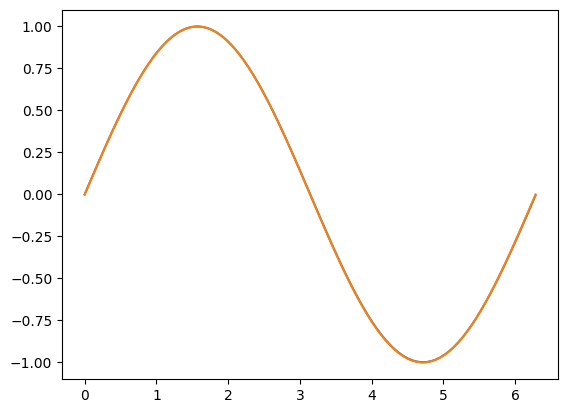

In [21]:
from matplotlib import pyplot as plt


x = torch.linspace(0,2*torch.pi,100).unsqueeze(dim = -1)
y = net(x)

y_pred = torch.sin(x)
print(x.shape,y.shape)
torch_line_plot(x,y)
torch_line_plot(x,y_pred)

Looks pretty good right!

# 1D Heat Equation
Lets move on to something a bit more difficult the Heat equation. This is a partial differential equation (PDE) as the heat $u(x,t)$ depends on both space and time.
$$
\frac{\partial u^2 }{\partial t^2} = k \frac{\partial u^2 }{\partial x^2}
$$

Where we set k=1 and *u* spans from $x\in\mathbb{R}$ (The whole number line) and
$t\in[0,10]$.

Here we provide only the initial condition:
$$
u(x,0) = \frac{1}{4\pi k \times 0.1}\exp(\frac{-x^2}{4k \times 0.1})
$$

Turns out this has an analytic solution for all $t > 0$:
$$
u(x,t) = \frac{1}{4\pi k \times (t+0.1)}\exp(\frac{-x^2}{4k \times (t+0.1)})
$$

In PINNs we can treat the time as simply another dimension in space so the first step is to create a grid of points $(x,t)$:

In [38]:
#Heat Equation
#Thermal Diffusivity
k = 1

# x points
x = torch.linspace(-10,10,100)
t = torch.linspace(0,10,50)

#Generate all (x,t) points above this is |x|*|t| number of points so 100**2 = 10,000 points

x_g,t_g = torch.meshgrid([x,t])



The points are represented as a grid structure. We need to flatten the grid into a long vector so we can pass it into the network. We create an $N\times 2$ tensor where $N$ is the number of collocation points to use 

In [39]:
#Flatten the grid into a single line tensor and then stack to form a [5000,2] tensor

x_f,t_f = x_g.flatten(),t_g.flatten()

points = torch.stack([x_f,t_f],dim = -1)

points.shape

torch.Size([5000, 2])

Create the data for the initial Condition:

Text(0.5, 1.0, 'plot of Initial condition')

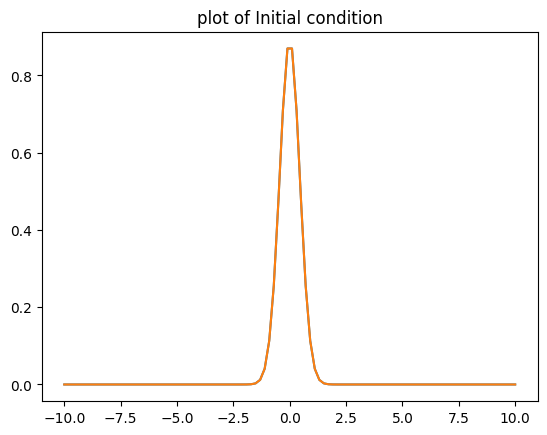

In [40]:
#Initial Conditions. Create a mask to find all the points at t =0 
IC_mask = points[:,-1] == t[0]
IC_x = points[IC_mask][:,0]
norm = lambda x,t : 1/torch.sqrt(4*torch.pi*k*(t+0.1))*torch.exp(-x**2/(4*k*(t+0.1)))

IC = norm(x,t[0])

#Show IC solution (No extra dims so can use normal plt.plot)
plt.plot(x,IC)


plt.plot(x,norm(x,torch.tensor([0])))
plt.title('plot of Initial condition')

In [41]:
#Change to 'cuda' if you want to use gpu!
device = 'cuda'
net = nn.Sequential(nn.Linear(2,200),nn.Tanh(),nn.Linear(200,1))

PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['x','t'], output_vars= ['u'])
PINN.set_derivatives(derivatives=['u_t','u_xx'])

optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
net = net.to(device=device)
points = points.to(device)
# For Loop
for i in range(10000):
    output = PINN.calculate(points)
    out = output['all']
    #Spring Equation is u_tt + u = 0
    residual = (k*out['u_xx'] - out['u_t']).pow(2).mean()

    #Data Fitting or in this case IC fitting
    data = (out['u'][IC_mask] - IC.to(device)).pow(2).mean()

    loss = data + residual
    print(f'Epoch {i} Total Loss{float(loss)}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 Total Loss0.05232103914022446
Epoch 1 Total Loss0.047005727887153625
Epoch 2 Total Loss0.042260460555553436
Epoch 3 Total Loss0.039217494428157806
Epoch 4 Total Loss0.03564458712935448
Epoch 5 Total Loss0.03337400034070015
Epoch 6 Total Loss0.030789505690336227
Epoch 7 Total Loss0.028501609340310097
Epoch 8 Total Loss0.026880579069256783
Epoch 9 Total Loss0.02506229840219021
Epoch 10 Total Loss0.023616738617420197
Epoch 11 Total Loss0.022632457315921783
Epoch 12 Total Loss0.02155797742307186
Epoch 13 Total Loss0.020790569484233856
Epoch 14 Total Loss0.02031821198761463
Epoch 15 Total Loss0.019739655777812004
Epoch 16 Total Loss0.01933997869491577
Epoch 17 Total Loss0.01908334717154503
Epoch 18 Total Loss0.018698936328291893
Epoch 19 Total Loss0.018426649272441864
Epoch 20 Total Loss0.018227139487862587
Epoch 21 Total Loss0.017928780987858772
Epoch 22 Total Loss0.017726752907037735
Epoch 23 Total Loss0.0175532978028059
Epoch 24 Total Loss0.01730051450431347
Epoch 25 Total Loss0.


## Animate results
well animate the diffusion of heat (we can also plot the result as a surface). you can see that the results aren't too bad! If you want to increase accuracy try changing some of the things such as:
- Number of Epochs
- Network
- number of collocation points
- Optimizer


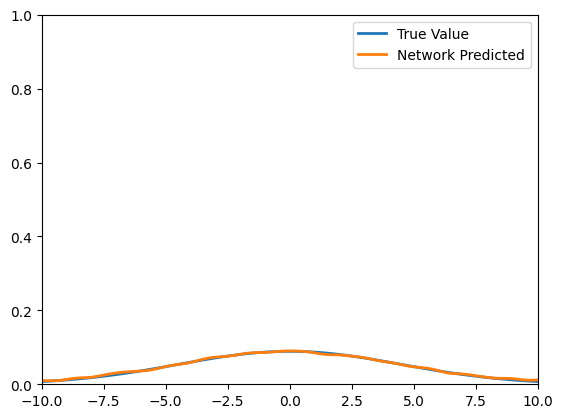

In [44]:
from torch import tensor
import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig = plt.figure()
axis = plt.axes(xlim =(-10, 10),
				ylim =(0, 1))

line, = axis.plot([], [], lw = 2,label = 'True Value')
line2, = axis.plot([], [], lw = 2,label = 'Network Predicted')
k=1

def init():
	line.set_data([], [])
	return line,

# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []
norm = lambda x,t : 1/torch.sqrt(4*torch.pi*k*(t+0.1))*torch.exp(-x**2/(4*k*(t+0.1)))

points = points.to('cpu')
net = net.to('cpu')
plt.legend()
# animation function
def animate(i):
    x = torch.linspace(-10, 10, 100)
    t = tensor([i*0.1])
    y_true = norm(x,t)  # Update the y-values based on the frame number
    
    t_net = torch.ones_like(x)*t

    points = torch.stack([x,t_net],dim = -1)
    y_pred = net(points)

    line.set_data(x,y_true)
    line2.set_data(x,y_pred.detach().squeeze())
    return (line,line2)
	

# calling the animation function	
anim = animation.FuncAnimation(fig, animate,
							init_func = init,
							frames = 100,
							interval = 20,
							blit = True)

# saves the animation in our desktop
anim.save('Heat_Equation.mp4', writer = 'ffmpeg', fps = 10)